# Reproducing bit flip and phase flip scaling results from Lescanne 2020

This notebook reproduces results from the [seminal paper](https://arxiv.org/pdf/1907.11729.pdf) by Raphaël Lescanne in 2020 using a noisy cat qubit simulator.

The emulator is configured to act as a digital twin of the cat qubit used in the paper in 2020.
It does not represent the current performance of Alice & Bob's cat qubits.

## Helper code (skip)

In [1]:
import numpy as np

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
from tqdm.notebook import tqdm
import warnings

# set default plot parameters
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',

    'font.family': 'serif',
    'font.size': 16,

    'figure.dpi': 72.0,

    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 5.0,
    'xtick.minor.size': 2.5,
    'ytick.major.size': 5.0,
    'ytick.minor.size': 2.5,
    'xtick.minor.visible': True,
    'ytick.minor.visible': True,

    'axes.grid': True,
    'axes.titlesize': 'larger',
    'axes.labelsize': 'larger',
    'legend.fontsize': 'larger',
    'grid.color': 'gray',
    'grid.linestyle': '--',
    'grid.alpha': 0.3,

    'lines.linewidth': 1.0,
    
    'figure.figsize': (16, 8)
})

In [3]:
def fitted_curve(t, T, a, b):
    return a * np.exp(- t / T) + b

def fit_typical_time(delay_durations, probs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        opt, _ = sp.optimize.curve_fit(
            fitted_curve, delay_durations, probs, 
            p0=[np.median(delay_durations), probs[0] - probs[-1], probs[-1]],
            method='trf'
        )
        return opt

## Instantiating the emulator

In [4]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from AliceBobQPU import AliceBobQPU

QPU = AliceBobQPU('EMU:1Q:LESCANNE_2020')

## $T_{bf}$ as a function of $\bar n = |\alpha|^2$

In [5]:
from qat.lang import Program, I, AbstractGate, QRoutine

def delay(duration_us):
    routine = QRoutine()
    wires = routine.new_wires(1)
    I(wires[0])
    return routine

delay_gate = AbstractGate('delay', [float], arity=1, circuit_generator=delay)

In [6]:
def build_bit_flip_prog(delay_duration_us: float) -> Program:
    prog = Program()
    q = prog.qalloc(1)
    c = prog.calloc(1)
    prog.reset(q[0])
    delay_gate(delay_duration_us)(q[0])
    # `delay_gate` is currently handled as an identity gate by the QPU, duration is ignored
    prog.measure(q, c)
    return prog

In [7]:
circ = build_bit_flip_prog(10).to_circ()
circ.display()

In [8]:
nbars = range(1, 8)
delay_durations_us = np.logspace(1, 4, 10)
shots = 10000

In [9]:
tbf_fitted = []

for nbar in tqdm(nbars):
    results = []
    QPU = AliceBobQPU('EMU:1Q:LESCANNE_2020', average_nb_photons=nbar)
    for delay_duration_us in delay_durations_us:
        prog = build_bit_flip_prog(delay_duration_us)
        job = prog.to_circ().to_job(nbshots=shots)
        results.append(QPU.submit(job))

    flip_fractions = []
    for res in results:
        for sample in res:
            if(sample.state[0] == 1):
                flip_fractions.append(sample.probability/shots)

    Tbf, a, b = fit_typical_time(delay_durations_us, flip_fractions)
    tbf_fitted.append(Tbf)

  0%|          | 0/7 [00:00<?, ?it/s]

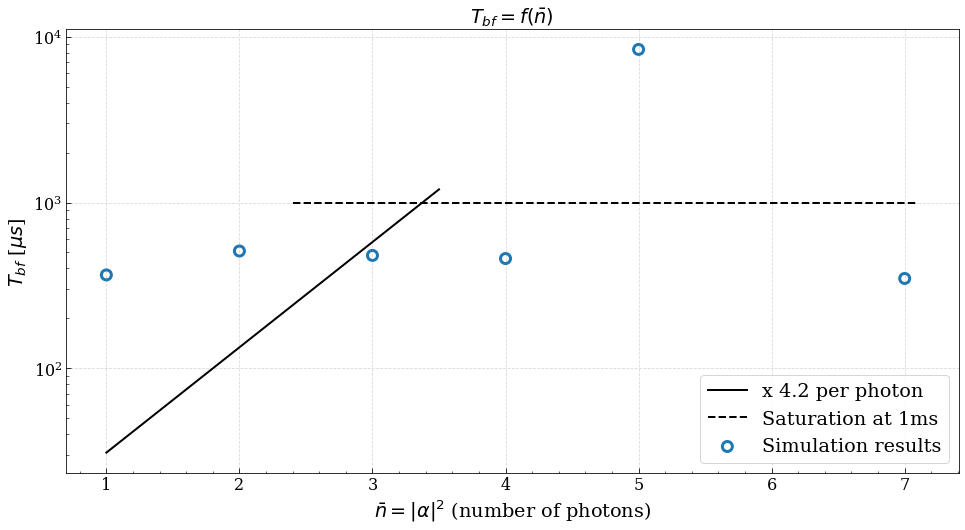

In [10]:
plt.figure()
plt.title('$T_{bf}=f(\\bar{n})$')
plt.xlabel('$\\bar{n} = |\\alpha|^2$ (number of photons)')
plt.ylabel('$T_{bf}$ [$\mu s$]')
plt.plot([1, 3.5], [3.1e1, 1.2e3], c='k', lw=2, label='x 4.2 per photon')
plt.plot([2.4, 7.1], [1e3, 1e3], c='k', ls='--', lw=2, label='Saturation at 1ms')
plt.scatter(nbars, tbf_fitted, facecolors='none', edgecolors='tab:blue', s=100, lw=3, label='Simulation results')
plt.legend(loc='lower right')
plt.semilogy()
plt.show()

Corresponding plot in the paper: 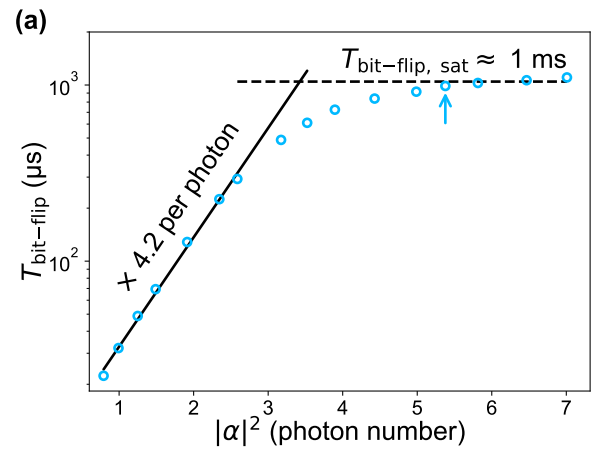

## $T_{pf}$ as a function of $\bar n = |\alpha|^2$

In [20]:
from qat.lang import H, X, Z

def initialize(state):
    routine = QRoutine()
    wires = routine.new_wires(1)
    if state == '0':
        I(wires)
    elif state == '1':
        X(wires)
    elif state == '+':
        H(wires)
    elif state == '-':
        H(wires)
        Z(wires)
    return routine

initialize_gate = AbstractGate('initialize', [str], arity=1, circuit_generator=initialize)

def build_phase_flip_prog(delay_duration_us) -> Program:
    prog = Program()
    q = prog.qalloc(1)
    c = prog.calloc(1)
    initialize_gate('+')(q[0])
    delay_gate(delay_duration_us)(q[0])
    # `delay_gate` is currently handled as an identity gate by the QPU, duration is ignored
    prog.measure(q, c)
    return prog

In [21]:
circ = build_phase_flip_prog(1)
circ.display()

In [22]:
nbars = range(1, 8)
delay_durations_us = np.logspace(-2, 2, 10)
shots = 10000

In [23]:
tpf_fitted = []

for nbar in tqdm(nbars):
    results = []
    QPU = AliceBobQPU('EMU:1Q:LESCANNE_2020', average_nb_photons=nbar)
    for delay_duration_us in delay_durations_us:
        prog = build_phase_flip_prog(delay_duration_us)
        job = prog.to_circ().to_job(nbshots=shots)
        results.append(QPU.submit(job))

    flip_fractions = []
    for res in results:
        for sample in res:
            if(sample.state[0] == 1):
                flip_fractions.append(sample.probability/shots)

    Tpf, a, b = fit_typical_time(delay_durations_us, flip_fractions)
    tbf_fitted.append(Tpf)

  0%|          | 0/7 [00:00<?, ?it/s]

TranspilerError: 'Unable to translate the operations in the circuit: ["measure", "h", "initialize"] to the backend\'s (or manually specified) target basis: {"store", "rz", "barrier", "measure", "delay", "snapshot", "z", "initialize", "measure_x"}. This likely means the target basis is not universal or there are additional equivalence rules needed in the EquivalenceLibrary being used. For more details on this error see: https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes. BasisTranslator#translation-errors'

ValueError: x and y must be the same size

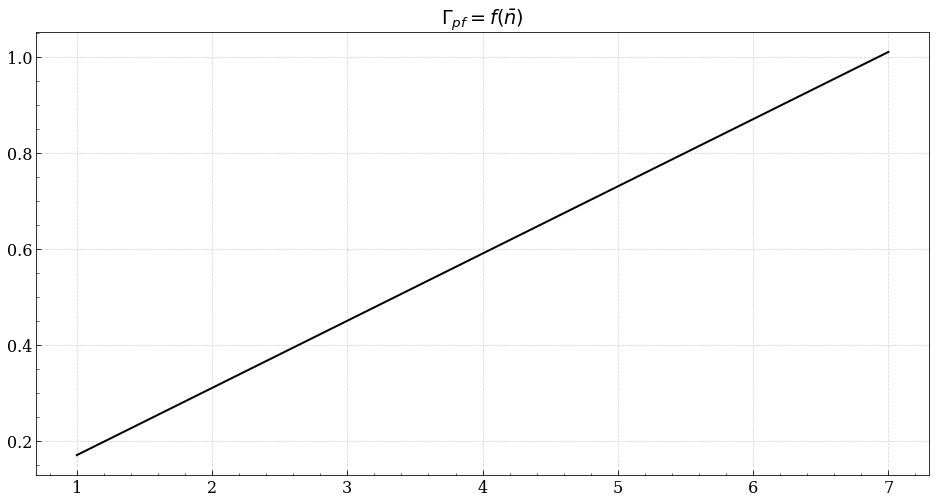

In [16]:
plt.figure()
plt.title('$\Gamma_{pf}=f(\\bar{n})$')
plt.plot([1, 7], [0.17, 1.01], c='k', lw=2, label='Linear increase of phase-flip rate')
plt.scatter(nbars, 0.5 / np.array(tpf_fitted), facecolors='none', edgecolors='tab:blue', s=100, lw=3, label='Simulation results')
plt.xlabel('$\\bar{n} = |\\alpha|^2$ (number of photons)')
plt.ylabel('$\Gamma_{pf}/2\pi$ [MHz]')
plt.legend(loc='lower right')
plt.show()

Corresponding plot in the paper: 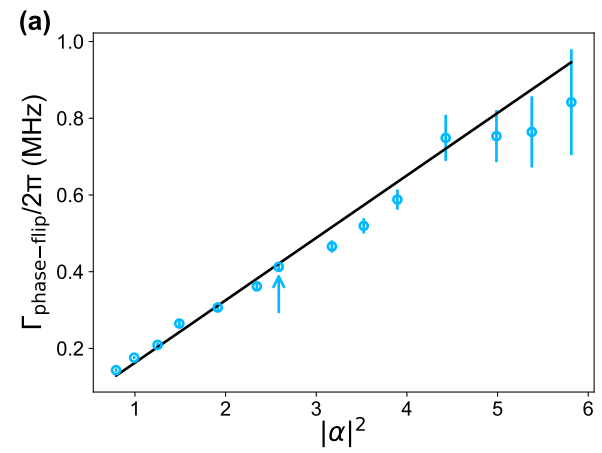